# An Analysis of a 1D Scalar and Vector Advection Equation 

## Import Packages 

In [1]:
using LinearAlgebra
using DifferentialEquations
using SparseArrays
using FFTW 
using BenchmarkTools 
using Plots 

## Section 1: Introduction 

Here we study the scalar advection equation. 

## Section 2: Analytical Reference Solution 

To do:   
1. plot the wave travelling in opposite direction;
1. plot the wave with anti-periodic boundary conditions; 

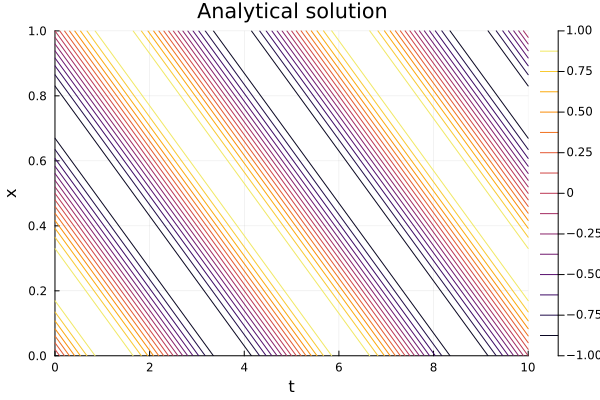

In [2]:
# pls observe the sign + in the analytical solution 
# pls observe the factor 2 to obtain a periodic solution 
function genAnalyticalSolution(x,t,c)
    return sin(2*pi*x + 2*pi*c*t)
end 

# set number of elements in space, the number of time samples and number of modes 
nelements = 100
Nt = 1000

#..construct the 1D spatial x-mesh and the spatial modes 
nnodes = nelements+1; h = 1/nelements; h2=h*h; 
x = Vector(0:h:1); 

#..construct temporal t-mesh  
Tend = 10; dt = Tend/Nt; 
t = Vector(0:dt:Tend);

#..set wave velocity and damping coefficients 
c = .2;
gamma = 0.5 # 0.5 

#..initialize and construct analytical solution 
uanal = [genAnalyticalSolution(xi,tj,c) for xi in x, tj in t]

p1 = contour(t,x,uanal)
xlabel!("t") 
ylabel!("x")
title!("Analytical solution")

plot(p1)

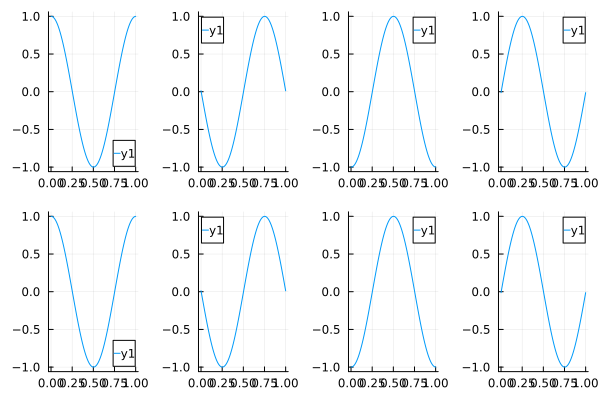

In [3]:
# plot time traces 
p1 = plot(x,uanal[:,div(Nt,8)])
p2 = plot(x,uanal[:,div(2*Nt,8)])
p3 = plot(x,uanal[:,div(3*Nt,8)])
p4 = plot(x,uanal[:,div(4*Nt,8)])
p5 = plot(x,uanal[:,div(5*Nt,8)])
p6 = plot(x,uanal[:,div(6*Nt,8)])
p7 = plot(x,uanal[:,div(7*Nt,8)])
p8 = plot(x,uanal[:,div(8*Nt,8)])
plot(p1,p2,p3,p4,p5,p6,p7,p8,layout=(2,4))

## Section 3: Spatial Discretization: Construct the One-Dimensional Advection Matrix

Need to add upwind scheme? 

In [8]:
# struct to hold entire mesh
struct Mesh
  #..number of nodes of the mesh..   
  nnodes::Int64
  #..number of elements of the mesh..
  nelements::Int64 
  #..vector of x-coordinates of nodes of the mesh..
  nodes::Vector{Float64}
  #..vector of x-coordinates of nodes of the mesh..
  midpoints::Vector{Float64}    
end 

# function to generate a mesh on the interval 0 <= x <= 1.   
# we limit the type of input to be Int64 
function genMesh(nelements::Int64)::Mesh
    h = 1/nelements 
    nnodes = nelements+1
    nodes = Vector{Float64}(0:h:1) 
    midpoints = (nodes[2:end] - nodes[1:end-1])/2
    mesh = Mesh(nnodes,nelements,nodes,midpoints)     
    return mesh;
end 

# generate global stiffness matrix 
function genAdvMat(mesh::Mesh)

    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes    = nelements+1
    
    #..set mesh width and square of mesh width 
    h = 1/nelements

    #..construct the coefficient matrix with our the boundary conditions 
    e = ones(nnodes); #..note that ones(N+1,1) does *not* work here 
    A = Bidiagonal(-e, e[2:end], :U); 
    A = (1/h)*A;     
   
    return A; 
    
end

# generate global stiffness matrix 
function genAdvMat2(mesh::Mesh)

    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes    = nelements+1
    
    #..set mesh width and square of mesh width 
    h = 1/nelements

    #..construct the coefficient matrix with our the boundary conditions 
    e = ones(nelements); 
    A = Bidiagonal(-e, e[2:end], :U); 
    A = (1/h)*A;     
   
    return A; 
    
end

function genVector(mesh, sourceFct::F) where F 

    #..recover mesh nodes  
    nodes = mesh.nodes
    
    #..set vector values using broadcasting (dot syntax)  
    f = sourceFct.(nodes)
   
    return f; 
end

function genBoundaries!(mesh,A,f)
    
    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes = mesh.nnodes 
    
    #..set mesh width and square of mesh width 
    h = 1/nelements
    
    A = sparse(A)
    A[end,end] = 0; # A[end,1] = -1   
    f[end] = 0 

    return A,f   

end

function genBoundaries2!(mesh,A,f)
    
    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes = mesh.nnodes 
    
    #..set mesh width and square of mesh width 
    h = 1/nelements
    
    A = sparse(A)
    A[end,1] = 1/h   
    f[end] = 0 

    return A,f   

end

genBoundaries2! (generic function with 1 method)

In [9]:
nelements = 4
mesh = genMesh(nelements)
myfct(x) = 0 
A = genAdvMat2(mesh); f = genVector(mesh, myfct) 
A,f = genBoundaries2!(mesh,A,f);

In [10]:
display(A)

4×4 SparseMatrixCSC{Float64, Int64} with 8 stored entries:
 -4.0   4.0    ⋅     ⋅ 
   ⋅   -4.0   4.0    ⋅ 
   ⋅     ⋅   -4.0   4.0
  4.0    ⋅     ⋅   -4.0

## Section 4: Time Integration of the (Non-)Linear Problem

To do: 
1. study the effect of the spatial mesh resolution 
1. study the effect of the non-linearity  

In [11]:
nelements = 100
mesh = genMesh(nelements)
myfct(x) = 0 
A = genAdvMat(mesh); f = genVector(mesh, myfct) 
A,f = genBoundaries!(mesh,A,f);

In [14]:
function advection_system!(du,u,p,t)
    du .= (1/c)*A*u
    # du .= (1/c)*(0.1*u).*A*u 
    u[end] = u[1]    
end
 
u0 = [genAnalyticalSolution(xi,0,c) for xi in mesh.nodes]

tspan = (0.0,.3)

prob = ODEProblem(advection_system!,u0,tspan)
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8, save_everystep = true);

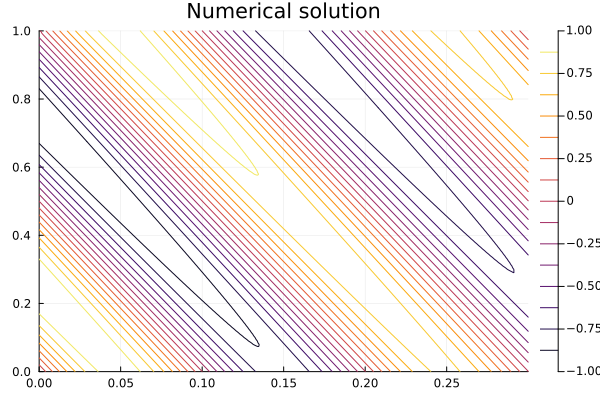

In [16]:
posind = 1:mesh.nnodes; 
U  = sol[posind,:]
p1 = contour(sol.t,mesh.nodes,U)
title!("Numerical solution")

In [17]:
length(sol.t)

10032

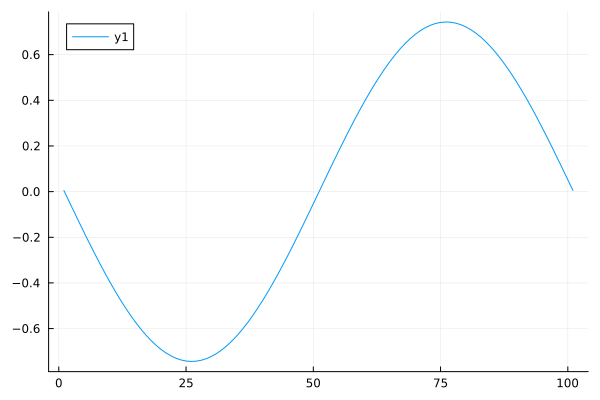

In [18]:
plot(U[:,div(length(sol.t),1)])

## Section 7: Spectral Analysis for Time Traces 

In [ ]:
unump1 = U[div(nelements,4),:]
unump2 = U[div(nelements,2),:]
unump3 = U[div(3*nelements,4),:]

p1 = plot(sol.t,unump1)
p2 = plot(sol.t,unump2)
p3 = plot(sol.t,unump3)
plot(p1,p2,p3,layout=(3,1)) 

In [ ]:
# perform FFT of sampled position data 
unumfp1 = fft(unump1)
unumfp2 = fft(unump2)
unumfp3 = fft(unump3)

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nt
fvec = Vector(0:fstep:fmax)

#..plot absolute value of FFT samples  
p1 = plot(fvec, 2.0/Nt * abs.(unumfp3[1:length(fvec)]),label="norm")
p2 = plot(fvec, angle.(unumfp3[1:length(fvec)]),label="phase")
plot(p1, p2)

## Section 8: Extend to Vector Valued Case  

How to formulate problem? How to find reference solution? How to extend to non-linear case?  

<b>Problem Formulation</b> We wish to solve the following problem for water height $\xi(x,t)$ and water $x$-velocity $u(x,t)$   

$$
\frac{\partial \xi}{\partial t} = -H \, \text{div}(u) = -  H \, \frac{\partial u}{\partial x}  
$$

$$
\frac{\partial u}{\partial t} = -g \, [ \text{grad}(\xi) ]_x + f(x,t) = - g \, \frac{\partial \xi}{\partial x} + f(x,t)
$$

supplied with periodic boundary conditions for both $\xi(x,t)$ and $u(x,t)$

$$
\xi(0,t) = \xi(1,t) \text{ and } u(0,t) = u(1,t) \, ,  
$$

and initial conditions for both fields. 

<b>Spatial Discretization</b>
We assume an uniform mesh with $N$ elements, $N+1$ nodes ($N-1$ internal nodes plus the left-most and right-most boundary node) and mesh spacing $h = 1/N$. We employ a staggered grid (or [Arkawa C-grid](https://en.wikipedia.org/wiki/Arakawa_grids) representation) representation for $\xi(x,t)$ and $u(x,t)$. This means here that we represent $\xi(x,t)$ in the midpoints and that we represent $u(x,t)$ in the nodes of the cells. Let ${\mathbf x}_m$ and ${\mathbf x}_m$ denote the vector of points and the vector of cell-centers, respctively. After spatial discretization, $\xi(x,t)$ is approximated by a grid vector ${\mathbf \xi} \in {\mathbb R}^{N}$ (midpoints). Similarly, $u(x,t)$ is approximated by a grid vector ${\mathbf u} \in {\mathbb R}^{N+1}$ (nodes). Due to the periodic boundary conditions imposed, only first $N$ velocity components are solved for. The last velocity component $u_{N+1}$ is recovered via $u_{N+1} = u_1$.   

<b>Finite Difference Approximation of the x-Derivative of $\xi$</b>
The $x$-component of the gradient of ${\mathbf \xi}$ can be computed in the first $N$ points. In the last ($(N+1)$-st point), this derivative is not required. We use a first order central finite difference scheme with mesh-width $h$. We more precisely have that  
$$
\frac{\partial \xi}{\partial x}(x=x_{i}) 
   \thickapprox \frac{\xi(x=x_{i+1/2}) - \xi(x=x_{i-1/2})}{h} \text{ for } 1 \leq i \leq N 
$$
where for $i=1$, we use periodicity to write that $\xi(x=x_{1-1/2}) = \xi(x=x_{N+1-1/2})$. We can then write that 

$$
\frac{\partial {\mathbf \xi}}{\partial x}({\mathbf x}[1:N]) = B \, {\mathbf \xi} \in {\mathbb R}^{N} 
$$

where the matrix $B$ represents the discrete gradient operator. After elimination of $\xi_{N+1}$ using the boundary conditions, the matrix $B \in {\mathbb R}^{N \times N}$ is almost lower bi-diagonal and has $1/h$ and $1-1/h$ as diagonal and upper-diagonal entry, respectively. The exception to this rule is that 
$B[1,end] = -1/h$. 

<b>Finite Difference Approximation of the x-Derivative of $u$</b> 
Similarly, we have that 
$$
\frac{\partial u}{\partial x}(x=x_{i}) 
   \thickapprox \frac{u(x=x_{i+1/2}) - u(x=x_{i-1/2})}{h} \text{ for } 1 \leq i \leq N 
$$
Note that for $i=1$, $u(x=x_{1-1/2})$ can be eliminated using the periodic boundary condition by $u(x=x_{N+1/2})$. Note that due to the periodic boundary condition, the value of $\frac{\partial u}{\partial x}(x=x_{N+1})$ is redundant. 

Note that for $i=N$ (last cell center) the last ($N+1$-st) component of the grid vector ${\mathbf \xi}$ is required. The dependency on this last component can be elimated using the periodic boundary condition (i.e. replace $\xi_{N+1}$ by $\xi_1$).

We can then write that 

$$
\frac{\partial {\mathbf u}}{\partial x}({\mathbf x}_m) = - B^T \, {\mathbf u}[1:N] \in {\mathbb R}^{N} 
$$  

Observe the introduction of the minus sign. 

<b>Semi-Discrete Equations</b>
The system of ODEs that result from spatial discretization can then we written as 

$$
\frac{d\mathbf{\xi}}{dt} = - H \, B^T \, \mathbf{u} \text{ (nodal equations)}
$$

$$
\frac{d \mathbf{u}}{dt} = g \, B \, \mathbf{\xi} + {\bf F}_{p} \text{ (cell-center equations)} 
$$ 

In [68]:
nelements = 99
mesh = genMesh(nelements)
myfct(x) = 0 
B = genAdvMat2(mesh); f = genVector(mesh, myfct) 
B,f = genBoundaries2!(mesh,B,f);

In [69]:
function advection_system!(du,u,p,t)
    p         = mesh 
    nelements = mesh.nelements
    nnodes    = mesh.nnodes  
    xi        = @view u[1:nelements]
    u         = @view u[nelements+1:end]
    du .= 0. 
    du[1:nelements]  .= -Transpose(B)*u[1:end-1]
    u[nnodes]         = u[1]
    du[nnodes+1:end] .= -B*xi .+ 0.01*sin(2*pi*t) 
end
 
xi0 = [0. for xi in mesh.midpoints]
u10 = [0. for xi in mesh.nodes]
u0  = [xi0; u10]

tspan = (0.0,1.)

p = mesh 

prob = ODEProblem(advection_system!,u0,tspan,p)
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8, save_everystep = true);

In [70]:
plot(sol.u)

In [45]:
xiind = 1:mesh.nelements; uind = mesh.nelements+1:mesh.nnodes+mesh.nelements; 
Nt = length(sol.t)
U1  = sol[xiind,:]
p1 = contour(sol.t,x,U1)
title!("U1")
U2  = sol[uind,:]
p2 = contour(sol.t,x,U2)
title!("U2")
plot(p1, p2, layout= (1,2))

ErrorException: Arrays have incorrect length or dimension.

In [ ]:
velind = 1:nnodes; posind = nnodes+1:2*nnodes; 
Nt = length(sol.t)
V  = sol[velind,:]
p1 = contour(sol.t,x,V)
title!("Numerical velocity")
U  = sol[posind,:]
p2 = contour(sol.t,x,U)
title!("Numerical position")
# plot(p1, p2, layout= (1,2))
p3 = plot(sol[velind,div(Nt,4)],label="1/4 vel")
p4 = plot(sol[posind,div(Nt,4)],label="1/4 pos")
p5 = plot(sol[velind,div(Nt,2)],label="1/2 vel")
p6 = plot(sol[posind,div(Nt,2)],label="1/2 pos")
p7 = plot(sol[velind,3*div(Nt,4)],label="3/4 vel")
p8 = plot(sol[posind,3*div(Nt,4)],label="3/4 pos")
plot(p1, p2, p3, p4, p5, p6, p7, p8, layout = (4,2)) 

## References 